## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import os
import pandas as pd
import muon as mu
import scanpy as sc
import mofax
import anndata as ad
from gprofiler import GProfiler

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load data

In [2]:
# Define the data and figure folder.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"
h_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/h/"

In [3]:
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

In [4]:
mofa_model = mofax.mofa_model(data_folder + "TEA/tea_mofa_15.hdf5")
H_mofa = {
    "H_rna": mofa_model.get_weights("rna"),
    "H_atac": mofa_model.get_weights("atac"),
    "H_adt": mofa_model.get_weights("adt")
}

In [5]:
H_mowgli = np.load(
    h_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()

## Define some interesting dimensions

In [6]:
dims_mofa = {
    "B cells": "mofa 0",
    "Monocytes": "mofa 1",
    "NK cells": "mofa 3",
    "MAIT T cells": "mofa 4",
    "CD8 T cells": "mofa 9",
    "Erythroid cells": "mofa 6",
}


In [7]:
dims_mowgli = {
    "NK cells": "mowgli 2",
    "MAIT T cells": "mowgli 9",
    "CD8 T cells": "mowgli 16",
    "Monocytes": "mowgli 32",
    "B cells": "mowgli 33",
    "Erythroid cells": "mowgli 7",
}


## Perform enrichment analysis

In [8]:
gp = GProfiler(return_dataframe=True)

In [9]:
def top_mowgli(dim, n):
    """
    Get the top n genes for a given dimension.
    """
    idx = H_mowgli["H_rna"][:, dim].argsort()[::-1][:n]
    return mdata["rna"].var_names[idx].str.replace("rna:", "").to_list()

def top_mofa(dim, n):
    """
    Get the top n genes for a given dimension.
    """
    idx = H_mofa["H_rna"][:, dim].argsort()[::-1][:n]
    return mdata["rna"].var_names[idx].str.replace("rna:", "").to_list()

In [10]:
query_mofa = {f"mofa {dim}": top_mofa(dim, 100) for dim in range(15)}
enr_mofa = gp.profile(
    organism="hsapiens",
    query=query_mofa,
    ordered=True,
    no_evidences=True,
    sources=["GO:BP"],
)
enr_mofa["minlogp"] = -np.log10(enr_mofa["p_value"])
enr_mofa["occurences"] = enr_mofa["native"].map(enr_mofa["native"].value_counts())
enr_mofa["frequency"] = enr_mofa["occurences"]/15
enr_mofa["method"] = "mofa"

query_mowgli = {f"mowgli {dim}": top_mowgli(dim, 100) for dim in range(50)}
enr_mowgli = gp.profile(
    organism="hsapiens",
    query=query_mowgli,
    ordered=True,
    no_evidences=True,
    sources=["GO:BP"],
)
enr_mowgli["minlogp"] = -np.log10(enr_mowgli["p_value"])
enr_mowgli["occurences"] = enr_mowgli["native"].map(enr_mowgli["native"].value_counts())
enr_mowgli["frequency"] = enr_mowgli["occurences"]/50
enr_mowgli["method"] = "mowgli"

In [11]:
enr = pd.concat((enr_mofa, enr_mowgli))

## Make .rnk file

In [61]:
pd.DataFrame(
    H_mowgli["H_rna"], index=mdata["rna"].var_names.str.replace("rna:", "")
).to_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/mowgli.rnk")
pd.DataFrame(
    H_mofa["H_rna"], index=mdata["rna"].var_names.str.replace("rna:", "")
).to_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/mofa.rnk")


## Explore

In [53]:
enr_mofa[(enr_mofa["query"] == "mofa 6") & (enr_mofa["description"].str.contains("iron"))][:10]

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,minlogp,occurences,frequency,method
142,GO:BP,GO:0048534,hematopoietic or lymphoid organ development,2.708887e-07,True,"""The process whose specific outcome is the pro...",938,62,18,21100,0.290323,0.019190,mofa 6,"[GO:0002520, GO:0048513]",6.567209,10,0.666667,mofa
329,GO:BP,GO:0007154,cell communication,9.605018e-06,True,"""Any process that mediates interactions betwee...",6508,84,52,21100,0.619048,0.007990,mofa 6,[GO:0009987],5.017502,12,0.800000,mofa
783,GO:BP,GO:0010646,regulation of cell communication,4.288971e-04,True,"""Any process that modulates the frequency, rat...",3336,84,33,21100,0.392857,0.009892,mofa 6,"[GO:0007154, GO:0050794]",3.367647,12,0.800000,mofa
822,GO:BP,GO:0010648,negative regulation of cell communication,5.128037e-04,True,"""Any process that decreases the frequency, rat...",1351,91,21,21100,0.230769,0.015544,mofa 6,"[GO:0007154, GO:0010646, GO:0048523]",3.290049,6,0.400000,mofa
1850,GO:BP,GO:0043500,muscle adaptation,2.317310e-02,True,"""A process in which muscle adapts, with conseq...",102,59,5,21100,0.084746,0.049020,mofa 6,"[GO:0003012, GO:0050896]",1.635016,2,0.133333,mofa


## Plot p-values

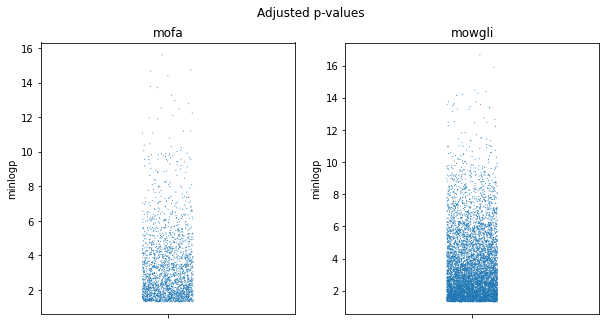

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Adjusted p-values")

sns.stripplot(data=enr_mofa, y="minlogp", ax=axes[0], s=1)
axes[0].set_title("mofa")

sns.stripplot(data=enr_mowgli, y="minlogp", ax=axes[1], s=1)
axes[1].set_title("mowgli")

plt.show()

## Plot selectivity

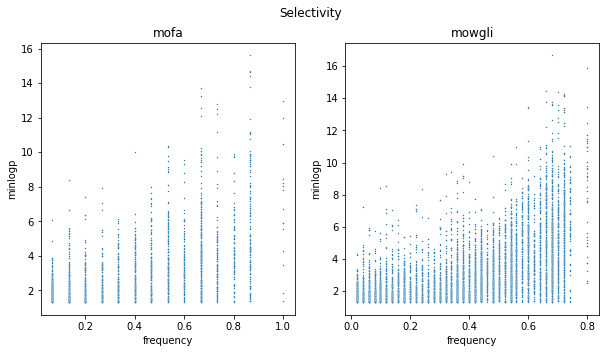

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Selectivity")

sns.scatterplot(data=enr_mofa, y="minlogp", x="frequency", ax=axes[0], s=2)
axes[0].set_title("mofa")

sns.scatterplot(data=enr_mowgli, y="minlogp", x="frequency", ax=axes[1], s=2)
axes[1].set_title("mowgli")

plt.show()

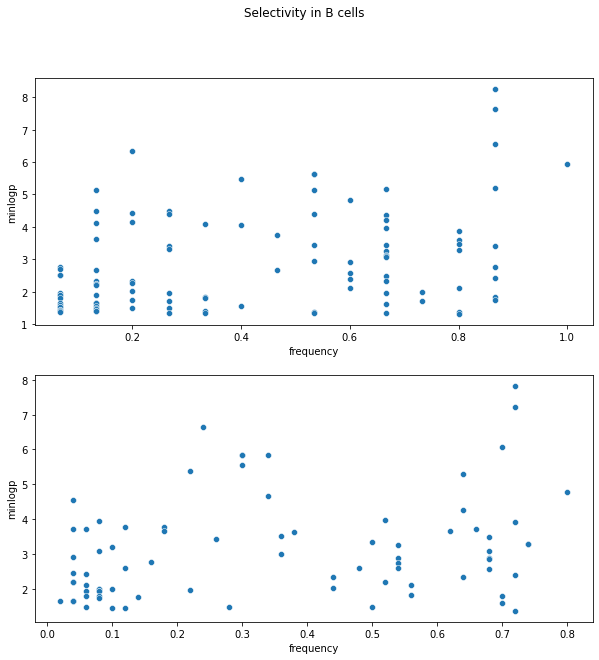

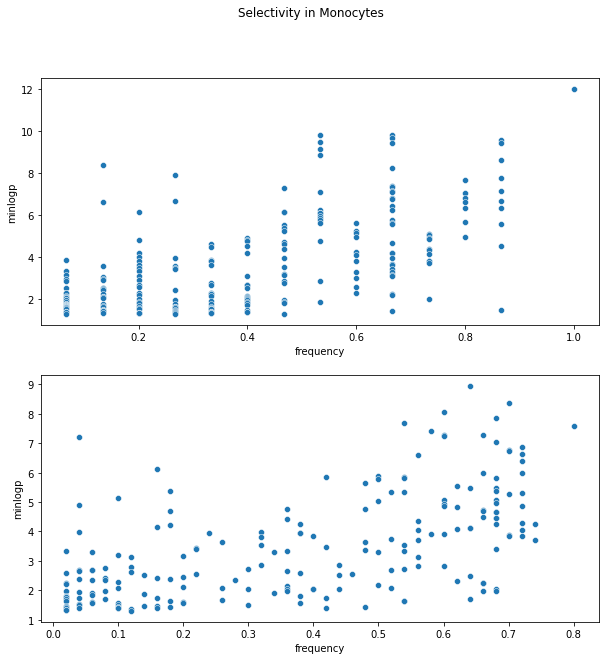

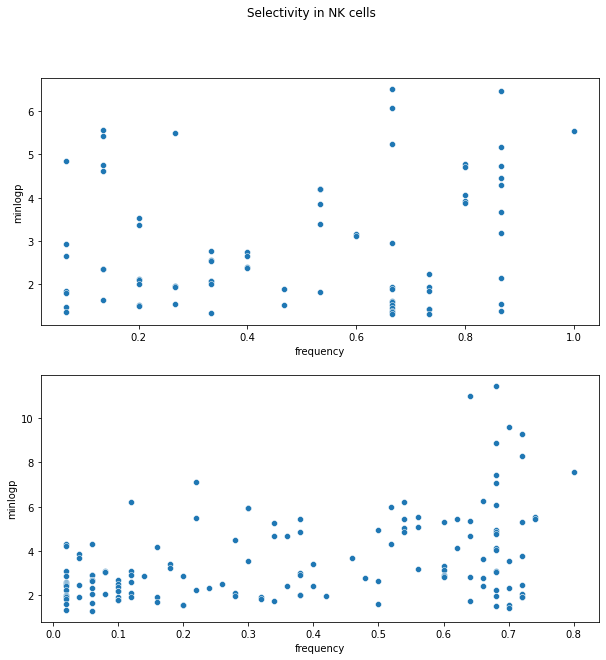

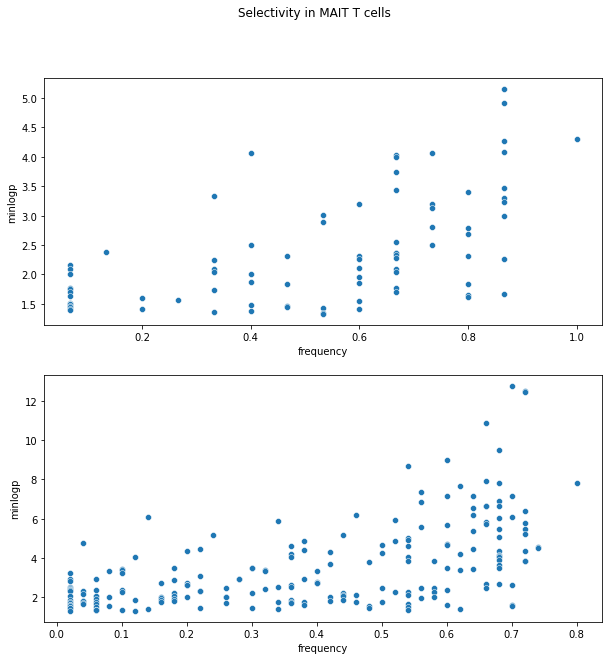

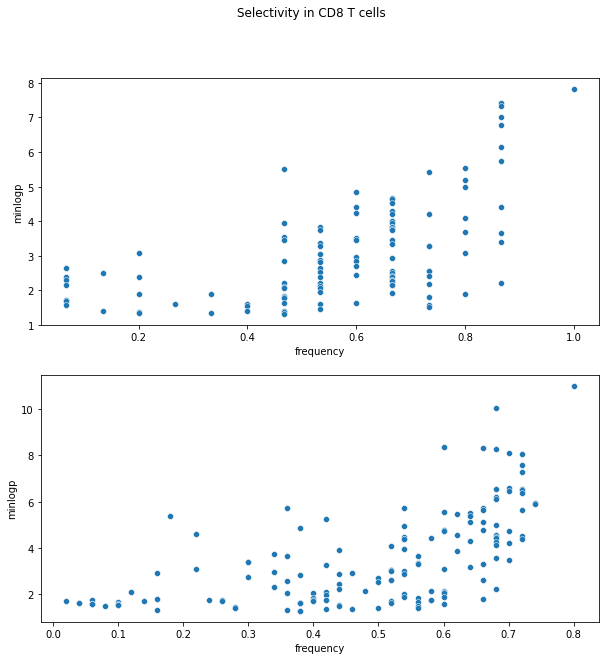

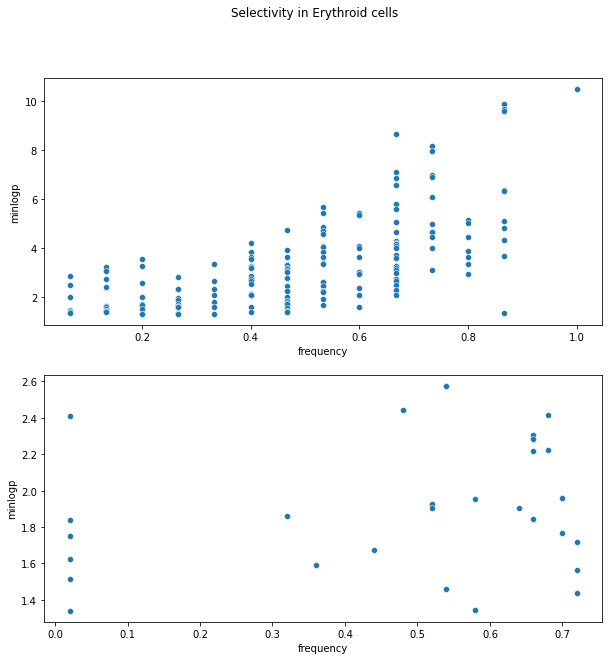

In [138]:
for celltype in dims_mofa:
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle("Selectivity in " + celltype)
    sns.scatterplot(
        data=enr_mofa[enr_mofa["query"] == dims_mofa[celltype]],
        y="minlogp",
        x="frequency",
        ax=axes[0],
    )
    sns.scatterplot(
        data=enr_mowgli[enr_mowgli["query"] == dims_mowgli[celltype]],
        y="minlogp",
        x="frequency",
        ax=axes[1],
    )
    plt.show()


In [139]:
np.setdiff1d(enr_mofa["name"].unique(), enr_mowgli["name"].unique())

array(['CD4-positive, CD25-positive, alpha-beta regulatory T cell differentiation',
       'CD8-positive, alpha-beta T cell lineage commitment',
       'activation of cysteine-type endopeptidase activity involved in apoptotic process',
       'antigen processing and presentation of endogenous antigen',
       'carboxylic acid transmembrane transport',
       'cardiac muscle adaptation',
       'cardiac muscle hypertrophy in response to stress',
       'cell cycle process', 'cell projection assembly',
       'cellular response to cAMP',
       'cellular response to lipoprotein particle stimulus',
       'cellular response to low-density lipoprotein particle stimulus',
       'chemotaxis', 'complement component C5a signaling pathway',
       'defense response to bacterium', 'establishment of localization',
       'face morphogenesis', 'female gamete generation',
       'filopodium assembly', 'foam cell differentiation',
       'forebrain development', 'formation of radial glial scaffolds

In [140]:
np.setdiff1d(enr_mowgli["name"].unique(), enr_mofa["name"].unique())

array(['B cell homeostasis', 'CD40 signaling pathway',
       'CD8-positive, alpha-beta T cell activation',
       'G protein-coupled acetylcholine receptor signaling pathway',
       'GDP metabolic process', 'GMP metabolic process', 'JNK cascade',
       'T cell mediated immunity', 'T-helper 2 cell differentiation',
       'acetylcholine receptor signaling pathway',
       'activation of GTPase activity',
       'adenylate cyclase-activating G protein-coupled receptor signaling pathway',
       'anatomical structure maturation', 'apoptotic signaling pathway',
       'blood vessel endothelial cell migration', 'bone resorption',
       'brain development', 'calcium ion homeostasis',
       'calcium ion transmembrane import into cytosol',
       'calcium ion transmembrane transport', 'calcium ion transport',
       'camera-type eye development', 'cardiac conduction',
       'cartilage development', 'cation transport',
       'cell migration in hindbrain',
       'cell morphogenesis invol

In [141]:
enr_mofa["native"].nunique()

686

In [142]:
enr_mowgli["native"].nunique()

804

In [143]:
np.mean(enr_mofa["native"].value_counts()/15)

0.21681243926141833

In [144]:
np.mean(enr_mowgli["native"].value_counts()/50)

0.1861442786069684

In [145]:
for celltype in dims_mofa:
    print("\n", celltype, ":")
    idx_query = (enr_mofa["query"] == dims_mofa[celltype])
    idx_occurences = (enr_mofa["frequency"] < .25)
    idx = idx_query & idx_occurences
    print("\n".join(enr_mofa[idx].head()["name"].to_list()))


 B cells :
B cell activation
B cell receptor signaling pathway
regulation of small GTPase mediated signal transduction
B cell proliferation
antigen processing and presentation of peptide or polysaccharide antigen via MHC class II

 Monocytes :
response to cytokine
cellular response to cytokine stimulus
regulation of transport
enzyme-linked receptor protein signaling pathway
regulation of biological quality

 NK cells :
natural killer cell mediated cytotoxicity
natural killer cell mediated immunity
leukocyte mediated cytotoxicity
Fc-gamma receptor signaling pathway
cell killing

 MAIT T cells :
muscle structure development
positive regulation of nitric oxide biosynthetic process
positive regulation of nitric oxide metabolic process
establishment of cell polarity
response to carbohydrate

 CD8 T cells :
positive T cell selection
filopodium assembly
CD4-positive, CD25-positive, alpha-beta regulatory T cell differentiation
T cell selection
positive regulation of protein localization to pl

In [146]:
for celltype in dims_mowgli:
    print("\n", celltype, ":")
    idx_query = (enr_mowgli["query"] == dims_mowgli[celltype])
    idx_occurences = (enr_mowgli["frequency"] < .25)
    idx = idx_query & idx_occurences
    print("\n".join(enr_mowgli[idx].head()["name"].to_list()))


 NK cells :
immune effector process
regulation of defense response
immune response-regulating cell surface receptor signaling pathway
T cell costimulation
leukocyte mediated immunity

 MAIT T cells :
positive regulation of protein metabolic process
positive regulation of cellular protein metabolic process
positive regulation of intracellular signal transduction
immune effector process
regulation of protein phosphorylation

 CD8 T cells :
T cell selection
positive T cell selection
immune response-regulating cell surface receptor signaling pathway
adaptive immune response
T cell receptor signaling pathway

 Monocytes :
response to cytokine
cellular response to lipid
response to lipid
cell-cell adhesion
cellular response to cytokine stimulus

 B cells :
B cell activation
immune response-regulating cell surface receptor signaling pathway
B cell receptor signaling pathway
B cell proliferation
mononuclear cell proliferation

 Erythroid cells :
G protein-coupled acetylcholine receptor signal